<a href="https://colab.research.google.com/github/ulissigroup/Physics-Enabled-AL-MLP/blob/master/al_relax_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook
import dftbook
dftbook.setup_colab()

     |████████████████████████████████| 296kB 5.0MB/s 
     |████████████████████████████████| 6.7MB 64.7MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 2.1MB 48.1MB/s 
     |████████████████████████████████| 12.8MB 245kB/s 
     |████████████████████████████████| 110.5MB 29kB/s 
     |████████████████████████████████| 3.8MB 52.8MB/s 
     |████████████████████████████████| 512kB 67.4MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ...

In [0]:
import os
import sys
import numpy as np
import random
import torch
import copy

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS, BFGSLineSearch
from ase.eos import EquationOfState
from ase.build import bulk
from ase import Atoms, Atom

from amptorch.active_learning.atomistic_methods import MDsimulate, Relaxation
from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import progressive_plot
from amptorch.model import CustomMSELoss

import multiprocessing as mp
from espresso import Espresso

### Create structure to relax: C/Cu(100)


In [0]:
energies = []
volumes = []
LC = [3.5, 3.55, 3.6, 3.65, 3.7, 3.75]

for a in LC:
  cu_bulk = bulk('Cu', 'fcc', a=a)

  calc = Espresso(xc='PBE',
              pw=500,
              calculation='scf',
              kpts=[12, 12, 12])

  cu_bulk.set_calculator(calc)

  e = cu_bulk.get_potential_energy()
  energies.append(e)
  volumes.append(cu_bulk.get_volume())


eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
aref=3.6
vref = bulk('Cu', 'fcc', a=aref).get_volume()

copper_lattice_constant = (v0/vref)**(1/3)*aref

slab = fcc100("Cu", a=copper_lattice_constant, size=(2, 2, 3))
ads = molecule("C")
add_adsorbate(slab, ads, 3, offset=(1, 1))
cons = FixAtoms(
    indices=[atom.index for atom in slab if (atom.tag == 3)]
)
slab.set_constraint(cons)
slab.center(vacuum=13.0, axis=2)
slab.set_pbc([True, True, False])
slab.wrap(pbc=[True, True, False])
slab.set_initial_magnetic_moments()

### Define our parent DFT calculator

In [0]:
base_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')

#Construct initial training data
slab.set_calculator(copy.copy(base_calc))
slab_energy = slab.get_potential_energy(apply_constraint=False)
slab_forces = slab.get_forces(apply_constraint=False)
slab.set_calculator(sp(slab, energy=slab_energy, forces=slab_forces))
training_images = [slab]

###Define model parameters and settings for ML only run

In [0]:
# Define symmetry functions
ase.io.write("slab.traj", slab)
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 6.0

ml_training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 20},
      "samples_to_retrain": 1,
      "Gs": Gs,
      "morse": False,
      "forcetraining": True,
      "cores": 10,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 300,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "ml_only_relax",
      "file_dir": "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/ml_relax/"
}

Run the active learning framework to learn the structure relaxation.

In [7]:
# Define AL scheme

learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=ml_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.1519          0.3163        0.0135     +  0.0689
      2          0.0151          0.1708        0.0007     +  0.0766
      3          0.0005          0.1567        0.0005     +  0.0864
      4          0.0029          0.0936        0.0002     +  0.0959
      5          0.0000          0.0331        0.0000     +  0.1032
      6          0.0000          0.0184        0.0000     +  0.1100
      7          0.0000          0.0149        0.0000     +  0.1115
      8          0.0000          0.0043        0.0000     +  0.0835
      9          0.0000          0.0035        0.0000     +  0.0096
     10          0.0000          0.0035        0.0000        0.0097
     11          0.0000          0.0035        0.0000        0.0096
     12          0.0000          0.0035        0.0000        0.

/usr/local/lib/python3.6/dist-packages/amptorch/active_learning/learner.py:95: UserWarning: # of samples exceeds # of available candidates! Defaulting to all available candidates
  parent_calc=self.parent_calc,


Streaming output truncated to the last 5000 lines.
    174          0.0432          2.8394        0.0007     +  0.1603
    175          0.0421          2.8167        0.0007     +  0.1510
    176          0.0519          2.7994        0.0007     +  0.1516
    177          0.0649          2.7656        0.0007     +  0.1546
    178          0.0477          2.7440        0.0006     +  0.1552
    179          0.0275          2.7274        0.0006     +  0.1581
    180          0.0274          2.7093        0.0006     +  0.1518
    181          0.0428          2.6802        0.0006     +  0.1555
    182          0.0411          2.6587        0.0006     +  0.1494
    183          0.0423          2.6369        0.0006     +  0.1544
    184          0.0410          2.6132        0.0006     +  0.1534
    185          0.0450          2.5856        0.0006     +  0.1506
    186          0.0515          2.5657        0.0006     +  0.1523
    187          0.0550          2.5489        0.0006     +  0.16

/usr/local/lib/python3.6/dist-packages/amptorch/active_learning/learner.py:95: UserWarning: # of samples exceeds # of available candidates! Defaulting to all available candidates
  parent_calc=self.parent_calc,


  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1         21.6758        453.5199      161.6156     +  0.2242
      2         16.0047        453.0208      157.3084     +  0.2419
      3         27.1989        345.0312      102.2362     +  0.2446
      4         16.4499         86.1782       10.5488     +  0.2539
      5          5.9170         62.4451        3.5490     +  0.2683
      6          2.5715         57.5417        2.5840     +  0.2823
      7          1.3535         49.9265        1.8869     +  0.2754
      8          2.4363         36.6601        1.1093     +  0.2752
      9          1.3717         28.1435        0.6237     +  0.2728
     10          1.2020         23.8235        0.4487     +  0.2682
     11          1.3809         21.0702        0.3654     +  0.2743
     12          1.2885         19.9841        0.3277     +  0.2783
     13          1.1785         18.6357        0

###Define model parameters and settings for ML+Morse run

In [0]:
# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 6.0

delta_training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 20},
      "samples_to_retrain": 1,
      "Gs": Gs,
      "morse": True,
      "forcetraining": True,
      "cores": 10,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 300,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "delta_relax",
      "file_dir": "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/"
}

ML+Morse AL - 20 iterations, 1 sample per iteration

In [7]:
delta_training_params["al_convergence"]["num_iterations"] = 20
delta_training_params["samples_to_retrain"] = 1
delta_training_params["filename"] = "delta_relax_20_1"

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=delta_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

os.system('rm -rf qe_*')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0101          3.7259        0.2777     +  0.2734
      2          0.0101          0.2010        0.0009     +  0.0816


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Streaming output truncated to the last 5000 lines.
     18          0.0014          0.0243        0.0002     +  0.1886
     19          0.0014          0.0223        0.0002     +  0.1727
     20          0.0014          0.0208        0.0002     +  0.1738
     21          0.0013          0.0198        0.0001     +  0.1728
     22          0.0014          0.0189        0.0001     +  0.1783
     23          0.0013          0.0182        0.0001     +  0.1807
     24          0.0013          0.0174        0.0001     +  0.1745
     25          0.0014          0.0163        0.0001     +  0.2154
     26          0.0014          0.0157        0.0001     +  0.1790
     27          0.0014          0.0154        0.0001     +  0.1836
     28          0.0014          0.0152        0.0001     +  0.1781
     29          0.0014          0.0151        0.0001     +  0.1738
     30          0.0013          0.0148        0.0001     +  0.1764
     31          0.0013          0.0145        0.0001     +  0.18

0

ML+Morse AL - 10 iterations, 2 sample per iteration

In [8]:
delta_training_params["al_convergence"]["num_iterations"] = 10
delta_training_params["samples_to_retrain"] = 2
delta_training_params["filename"] = "delta_relax_10_2"

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=delta_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

os.system('rm -rf qe_*')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0465          3.6813        0.2721     +  0.0672
      2          0.0103          0.2067        0.0009     +  0.0767
      3          0.0006          0.0621        0.0001     +  0.0856
      4          0.0004          0.0320        0.0000     +  0.0986
      5          0.0002          0.0192        0.0000     +  0.1013
      6          0.0000          0.0053        0.0000     +  0.1027
      7          0.0000          0.0044        0.0000     +  0.0102
      8          0.0000          0.0044        0.0000     +  0.0105
      9          0.0000          0.0044        0.0000     +  0.0099
     10          0.0000          0.0044        0.0000     +  0.0103
     11          0.0000          0.0044        0.0000     +  0.0103
     12          0.0000          0.0044        0.0000     +  0.

0

ML+Morse AL - 5 iterations, 4 sample per iteration

In [9]:
delta_training_params["al_convergence"]["num_iterations"] = 5
delta_training_params["samples_to_retrain"] = 4
delta_training_params["filename"] = "delta_relax_5_4"

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=delta_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

os.system('rm -rf qe_*')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.1287          3.8023        0.2974     +  0.0739
      2          0.0056          0.2064        0.0009     +  0.0811
      3          0.0002          0.0643        0.0001     +  0.1069
      4          0.0002          0.0392        0.0000     +  0.1072
      5          0.0001          0.0223        0.0000     +  0.1064
      6          0.0000          0.0040        0.0000     +  0.1136
      7          0.0000          0.0019        0.0000     +  0.0102
      8          0.0000          0.0019        0.0000     +  0.0110
      9          0.0000          0.0018        0.0000     +  0.0108
     10          0.0000          0.0018        0.0000     +  0.0108
     11          0.0000          0.0018        0.0000     +  0.0108
     12          0.0000          0.0018        0.0000     +  0.

0

ML+Morse AL - 3 iterations, 5 sample per iteration

In [10]:
delta_training_params["al_convergence"]["num_iterations"] = 3
delta_training_params["samples_to_retrain"] = 5
delta_training_params["filename"] = "delta_relax_3_5"

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=delta_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

os.system('rm -rf qe_*')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.1419          3.9664        0.3247     +  0.0651
      2          0.0080          0.2244        0.0010     +  0.0824
      3          0.0006          0.0727        0.0001     +  0.0827
      4          0.0001          0.0169        0.0000     +  0.1064
      5          0.0000          0.0039        0.0000     +  0.1004
      6          0.0000          0.0020        0.0000     +  0.0386
      7          0.0000          0.0018        0.0000     +  0.0103
      8          0.0000          0.0018        0.0000     +  0.0102
      9          0.0000          0.0018        0.0000     +  0.0100
     10          0.0000          0.0018        0.0000     +  0.0101
     11          0.0000          0.0018        0.0000     +  0.0100
     12          0.0000          0.0018        0.0000     +  0.

0

ML+Morse AL - 2 iterations, 10 sample per iteration

In [11]:
delta_training_params["al_convergence"]["num_iterations"] = 2
delta_training_params["samples_to_retrain"] = 10
delta_training_params["filename"] = "delta_relax_2_10"

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=delta_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

os.system('rm -rf qe_*')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.1189          3.7323        0.2857     +  0.0683
      2          0.0110          0.2280        0.0011     +  0.0855
      3          0.0004          0.0589        0.0001     +  0.0991
      4          0.0002          0.0117        0.0000     +  0.0997
      5          0.0000          0.0056        0.0000     +  0.1080
      6          0.0000          0.0032        0.0000     +  0.0905
      7          0.0000          0.0026        0.0000     +  0.0110
      8          0.0000          0.0026        0.0000     +  0.0129
      9          0.0000          0.0026        0.0000     +  0.0115
     10          0.0000          0.0026        0.0000     +  0.0113
     11          0.0000          0.0026        0.0000     +  0.0117
     12          0.0000          0.0026        0.0000     +  0.

0

ML+Morse AL - 2 iterations, 5 sample per iteration

In [12]:
delta_training_params["al_convergence"]["num_iterations"] = 2
delta_training_params["samples_to_retrain"] = 5
delta_training_params["filename"] = "delta_relax_2_5"

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=delta_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

os.system('rm -rf qe_*')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.2096          4.0541        0.3507     +  0.0734
      2          0.0221          0.3487        0.0027     +  0.0795
      3          0.0010          0.0803        0.0001     +  0.0854
      4          0.0001          0.0184        0.0000     +  0.1088
      5          0.0000          0.0039        0.0000     +  0.1225
      6          0.0000          0.0030        0.0000     +  0.0782
      7          0.0000          0.0029        0.0000     +  0.0118
      8          0.0000          0.0029        0.0000     +  0.0114
      9          0.0000          0.0028        0.0000     +  0.0110
     10          0.0000          0.0028        0.0000     +  0.0109
     11          0.0000          0.0028        0.0000     +  0.0137
     12          0.0000          0.0028        0.0000     +  0.

0

ML+Morse AL - 1 iterations, 5 sample per iteration

In [13]:
delta_training_params["al_convergence"]["num_iterations"] = 1
delta_training_params["samples_to_retrain"] = 5
delta_training_params["filename"] = "delta_relax_1_5"

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=training_images,
    training_params=delta_training_params,
    parent_calc=base_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
learner.learn(
    atomistic_method=Relaxation(
        initial_geometry=slab,
        optimizer=BFGS,
        fmax=0.01,
        steps=100,
    ),
    query_strategy=random_query
)

os.system('rm -rf qe_*')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.3069          3.7072        0.3220     +  0.0691
      2          0.0265          0.3136        0.0023     +  0.0778
      3          0.0020          0.0589        0.0001     +  0.0871
      4          0.0000          0.0270        0.0000     +  0.0968
      5          0.0001          0.0152        0.0000     +  0.1106
      6          0.0000          0.0025        0.0000     +  0.0846
      7          0.0000          0.0018        0.0000     +  0.0113
      8          0.0000          0.0018        0.0000     +  0.0109
      9          0.0000          0.0018        0.0000     +  0.0111
     10          0.0000          0.0018        0.0000     +  0.0122
     11          0.0000          0.0018        0.0000     +  0.0108
     12          0.0000          0.0018        0.0000     +  0.

0

In [0]:
# Compute the parent calculator (DFT) based relaxation
true_relax = Relaxation(slab, BFGS, fmax=0.01)
true_relax.run(base_calc, 'true_relax')

In [0]:
parent_traj = ase.io.read("./true_relax.traj", ":")

### Analysis

In [0]:
parent_traj = ase.io.read("./true_relax.traj", ":")
slab = ase.io.read("./slab.traj")

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def compute_loss(a, b):
  return np.sqrt(np.mean(np.sum((a - b)**2, axis=1)))

def get_energies(traj):
  return np.array([image.get_potential_energy() for image in traj])

def ermse(e1, e2, n):
  return np.sqrt(((e1-e2)/n)**2)

def residuals_plot(filename, true_relaxed, iterations):
    fig, ax1 = plt.subplots(figsize=(10,10))
    dft_energies = get_energies(true_relaxed)
    dft_steps = len(dft_energies)
    sns.lineplot(range(dft_steps), dft_energies-dft_energies, linewidth=2, label="DFT")
        
    for i in iterations:
        ml_relaxed = ase.io.read("{}_iter_{}.traj".format(filename, i), ":")
        ml_steps = len(ml_relaxed)
        if ml_steps<len(dft_energies):
          energies = get_energies(ml_relaxed)-dft_energies[:ml_steps]
        elif ml_steps>len(dft_energies):
          addition = np.array([dft_energies[-1]]*(ml_steps-len(dft_energies)))
          dft_energies = np.append(dft_energies, addition)
          energies = get_energies(ml_relaxed) - dft_energies
        else:
          energies = get_energies(ml_relaxed) - dft_energies
        sns.scatterplot(range(ml_steps), energies, s=80, label=f"AL iter. #{i}" )

    ax1.set_xlabel(r"Step", fontsize=25)
    ax1.set_ylabel("Residuals, eV", color="k", fontsize=25)
    ax1.tick_params(axis="both", labelsize=25)
    plt.legend(fontsize=18)
    plt.savefig(filename+"_progressive.png", dpi=300)

def learning_curve(filename, true_relaxed, samples_per_iter, num_iterations):
    distance_rmse = []
    data_size = list(range(0, samples_per_iter*num_iterations+1, samples_per_iter))

    for i in range(len(data_size)):
        ml_relaxed = ase.io.read("{}_iter_{}.traj".format(filename, i), "-1")
        loss = compute_loss(ml_relaxed.positions, true_relaxed.positions)
        distance_rmse.append(loss)

    fig, ax1 = plt.subplots(figsize=(10,10))
    ax1.plot(np.array(data_size)+1, distance_rmse, linewidth=5)
    ax1.set_xlabel("Training Images", fontsize=25)
    ax1.set_ylabel("Distance RMSE", fontsize=25)
    ax1.set_yscale("log")
    ax1.tick_params(axis="both", labelsize=25)
    ax1.set_xticks(np.array(data_size)+1)
    plt.savefig(filename+"_learning_curve.png", dpi=300)

def variable_learning(filenames, true_relaxed, error='distance', oal=False, oal_tol=0.05):
  fig, ax1 = plt.subplots(figsize=(15,15))
  if oal:
    oal_uncertainties = [image.info["uncertainty"][0] for image in oal_traj]
    dft_calls = []
    for idx, p in enumerate(oal_uncertainties):
      if p>oal_tol:
        dft_calls.append(idx)
    dft_calls = len(dft_calls)+1
    oal_relaxed = oal_traj[-1]
    if error == 'distance':
      loss = compute_loss(oal_relaxed.positions, true_relaxed.positions)
    elif error == 'energy':
      loss = ermse(oal_relaxed.get_potential_energy(), true_relaxed.get_potential_energy(), n=len(true_relaxed))
    ax1.scatter(dft_calls, loss, s=200, color="k", marker="x", label="OAL")
  for filename in filenames:
    splits = filename.split('_')
    print(splits)
    samples_per_iter = int(splits[-1])
    num_iterations = int(splits[-2])
    rmse = []
    data_size = list(range(0, samples_per_iter*num_iterations+1, samples_per_iter))

    for i in range(len(data_size)):
        ml_relaxed = ase.io.read("{}_iter_{}.traj".format(filename, i), "-1")
        if error == 'distance':
          loss = compute_loss(ml_relaxed.positions, true_relaxed.positions)
        elif error =='energy':
          loss = ermse(ml_relaxed.get_potential_energy(), true_relaxed.get_potential_energy(), n=len(true_relaxed))
        rmse.append(loss)

    ax1.plot(np.array(data_size)+1, rmse, linewidth=3, label=f"iterations={num_iterations}, samples={samples_per_iter}")
    ax1.set_xlabel("Training Images", fontsize=32.5)
    if error == 'distance':
      ax1.set_ylabel("Structure Error ($\AA$)", fontsize=32.5)
    elif error == 'energy':
      ax1.set_ylabel("Energy Error (eV/atom)", fontsize=32.5)
    ax1.set_yscale("log")
    ax1.tick_params(axis="both", labelsize=30)
    ax1.set_xticks(np.array(range(0, 20, 2))+1)
    plt.legend(fontsize=18)
    
  plt.savefig(f"/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/batch_{error}_learning_curve.png", dpi=300)

def compute_errors(ml_traj, parent_traj, ml_dft_traj=None):
    n = len(slab)

    al_energies = get_energies(ml_traj)
    parent_energies = get_energies(parent_traj)

    initial_structure = slab.positions
    print(f'Final AL Relaxed Energy: {al_energies[-1]}')
    if ml_dft_traj:
        dft_al_energies = get_energies(ml_dft_traj)
        print(f'DFT evaluation at AL structure: {dft_al_energies[-1]}\n')
    al_relaxed_structure = ml_traj[-1].positions

    print(f'Total number of DFT steps: {len(parent_traj)}')
    print(f'Final DFT Relaxed Energy: {parent_energies[-1]}\n')
    parent_relaxed_structure = parent_traj[-1].positions


    initial_structure_error = compute_loss(initial_structure, parent_relaxed_structure)
    relaxed_structure_error = compute_loss(al_relaxed_structure, parent_relaxed_structure)

    print(f'Initial structure rmse: {initial_structure_error}')
    print(f'AL relaxed structure rmse: {relaxed_structure_error}\n')
    if ml_dft_traj:
      print(f'energy_rmse_DFT@AL: {ermse(dft_al_energies[-1], parent_energies[-1], n)}')
    print(f'energy_rmse_AL: {ermse(al_energies[-1], parent_energies[-1], n)}')

def plot_relax(ml_traj_path, parent_traj, compute_parent=True):
    base_calc = Espresso(pw=500.0, 
                  calculation='scf',
                  kpts=(4,4,1),
                  xc='PBE')
    
    final_ml_traj = ase.io.read(ml_traj_path+".traj", ":")

    #Compute ML predicted energies
    ml_relaxation_energies = np.array([image.get_potential_energy() for image in final_ml_traj])

    if compute_parent:
      parent_evaluated_ml_traj = copy.deepcopy(final_ml_traj)
      #Compute actual energies for ML predicted structures
      # for image in parent_evaluated_ml_traj:
      #   image.set_calculator(copy.copy(base_calc))
      #   image.get_potential_energy(image)
      # ase.io.write(ml_traj_path+"_parent.traj", parent_evaluated_ml_traj)
      parent_evaluated_ml_traj = ase.io.read(ml_traj_path+"_parent.traj", ":")
      parent_evaluated_ml_energies = np.array([image.get_potential_energy() for image in parent_evaluated_ml_traj])
    else:
      parent_evaluated_ml_traj = None

    parent_relaxation_energies = np.array([image.get_potential_energy() for image in parent_traj])
    ml_steps = range(len(final_ml_traj))
    parent_steps = range(len(parent_traj))

    ref_energy = parent_relaxation_energies[0]

    fig, ax1 = plt.subplots(figsize=(10,10))
    ax1.set_xlabel(r"Step", fontsize=25)
    ax1.set_ylabel("Energy, eV", color="k", fontsize=25)
    sns.lineplot(parent_steps, parent_relaxation_energies-ref_energy, color='k', linewidth=5, label='DFT')
    sns.lineplot(ml_steps, ml_relaxation_energies-ref_energy, linewidth=3, label='ML')
    if compute_parent:
      sns.lineplot(ml_steps, parent_evaluated_ml_energies-ref_energy, linewidth=3, label='DFT@ML')
    ax1.tick_params(axis="both", labelsize=25)
    plt.legend(fontsize=18)
    fig.savefig(ml_traj_path+".png", dpi=300)
    plt.show()

    compute_errors(final_ml_traj, parent_traj, ml_dft_traj=parent_evaluated_ml_traj)
    os.system("rm -rf qe_*")



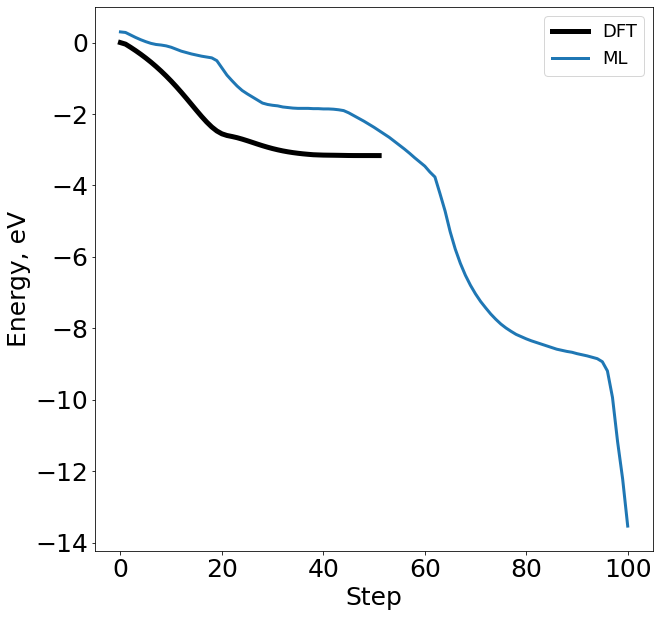

Final AL Relaxed Energy: -66081.3515625
Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.7108942355094146

energy_rmse_AL: 0.7979695440478211
['/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/ml', 'relax/ml', 'only', 'relax', '20', '1']


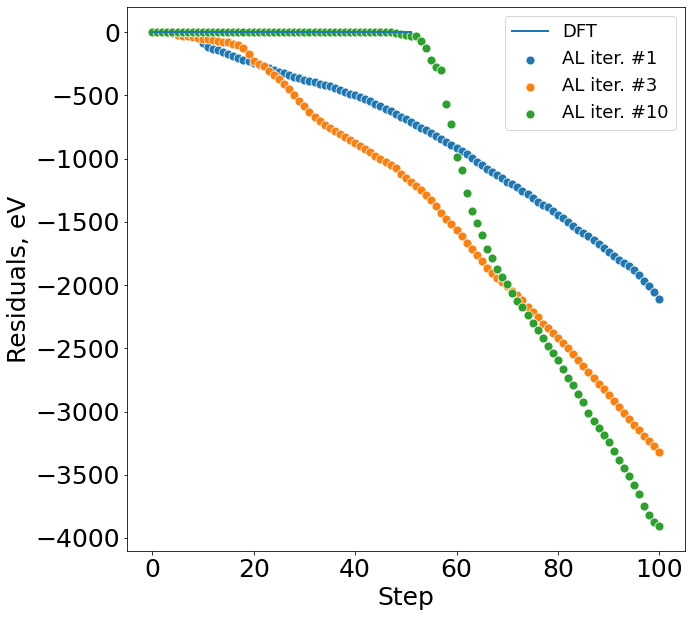

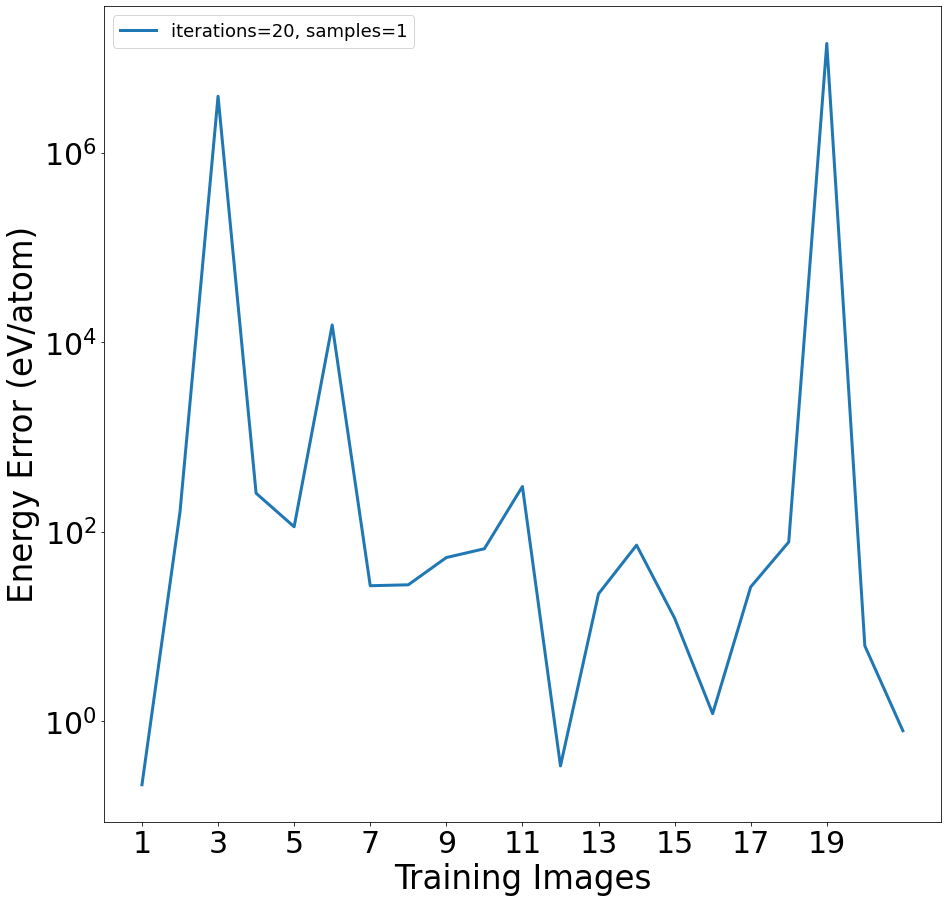

In [26]:
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/ml_relax/ml_only_relax_20_1_iter_20", parent_traj, compute_parent=False)
residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/ml_relax/ml_only_relax_20_1",
    parent_traj,
    [1, 3, 10])

variable_learning(
    ["/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/ml_relax/ml_only_relax_20_1"],
    parent_traj[-1],
    error='energy')

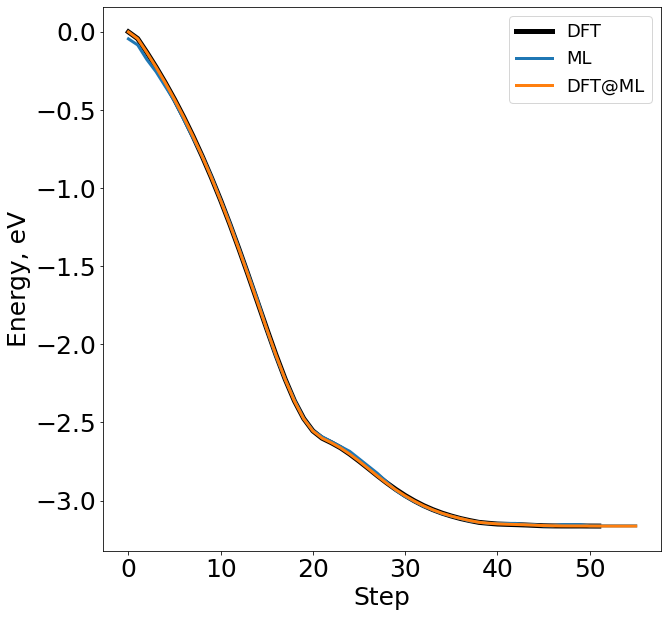

Final AL Relaxed Energy: -66070.9765625
DFT evaluation at AL structure: -66070.97799080894

Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.001231049844271203

energy_rmse_DFT@AL: 2.4908893884947665e-06
energy_rmse_AL: 0.0001073790291019787
['/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta', 'relax/delta', 'relax', '20', '1']
['/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta', 'relax/delta', 'relax', '10', '2']
['/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta', 'relax/delta', 'relax', '3', '5']
['/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta', 'relax/delta', 'relax', '2', '10']
['/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta', 'relax/delta', 'relax', '20', '1']
['/content/drive/My Drive/CMU - PhD/Research/AMPTo

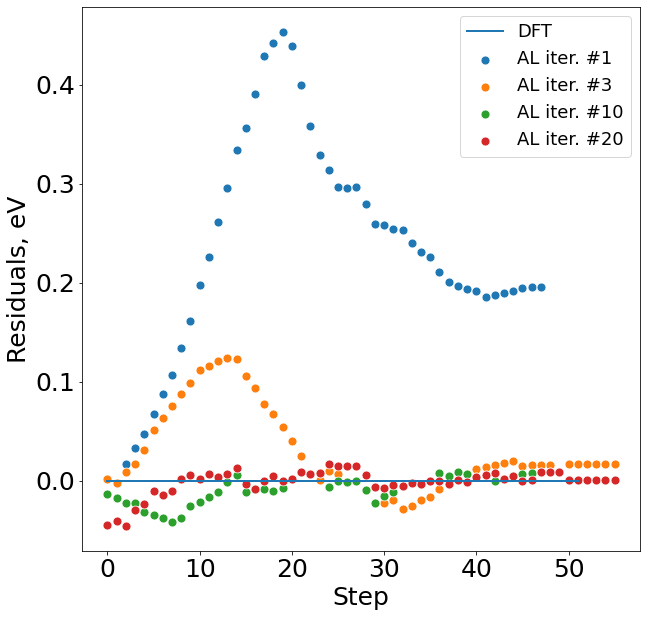

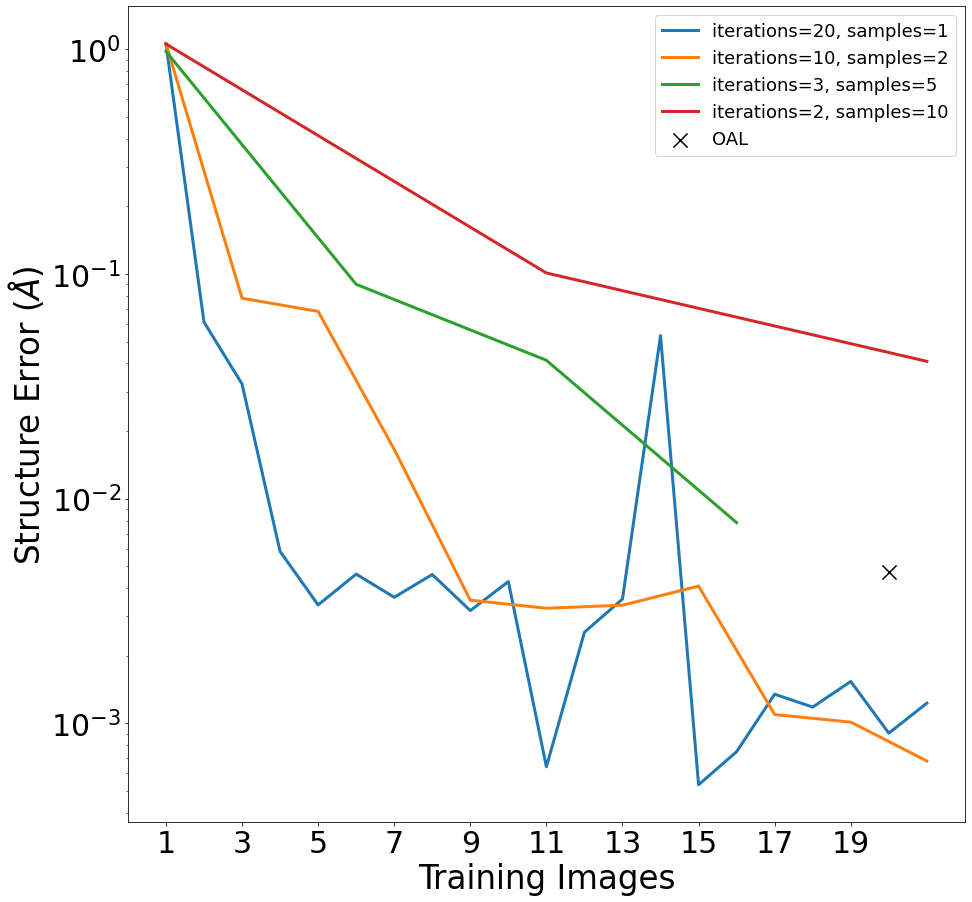

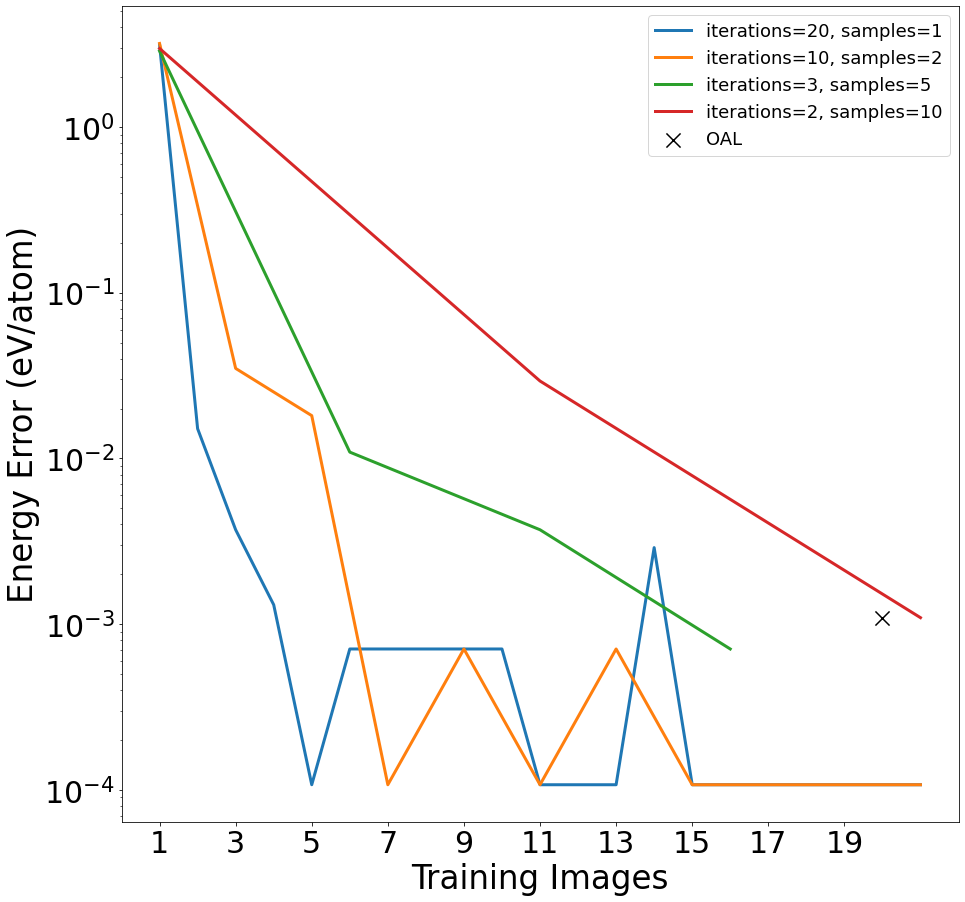

In [27]:
oal_traj = ase.io.read("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/relax_oal.traj", ":")
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_20_1_iter_20", parent_traj, compute_parent=True)

residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_20_1",
    parent_traj,
    [1, 3, 10, 20])

variable_learning(
    ["/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_20_1",
     "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_10_2",
     "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_3_5",
     "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_2_10"],
    parent_traj[-1],
    error='distance',
    oal=oal_traj)

variable_learning(
    ["/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_20_1",
     "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_10_2",
     "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_3_5",
     "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_2_10"],
    parent_traj[-1],
    error='energy',
    oal=oal_traj)

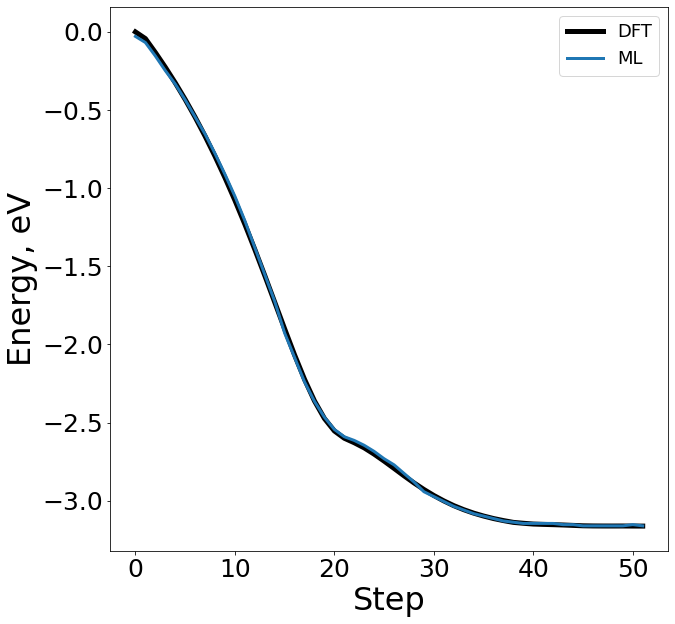

Final AL Relaxed Energy: -66070.9765625
Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.0006811251381441281

energy_rmse_AL: 0.0001073790291019787


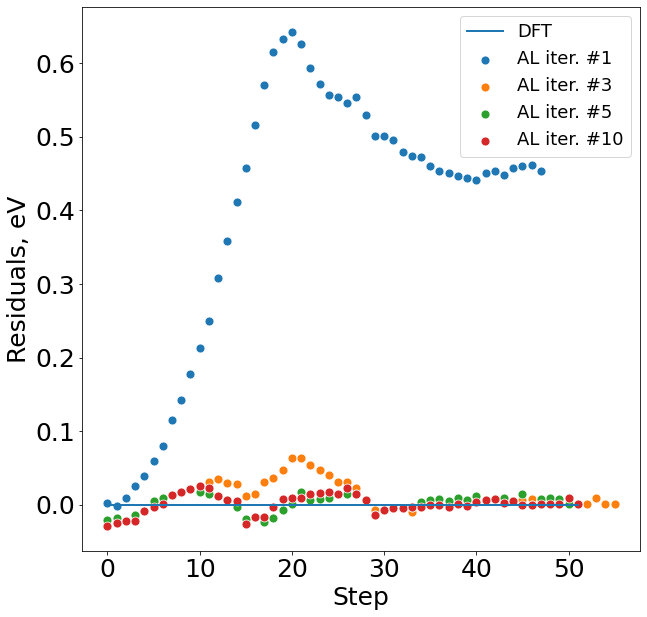

In [254]:
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_10_2_iter_10", parent_traj, compute_parent=False)
residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_10_2",
    parent_traj,
    [1, 3, 5, 10])


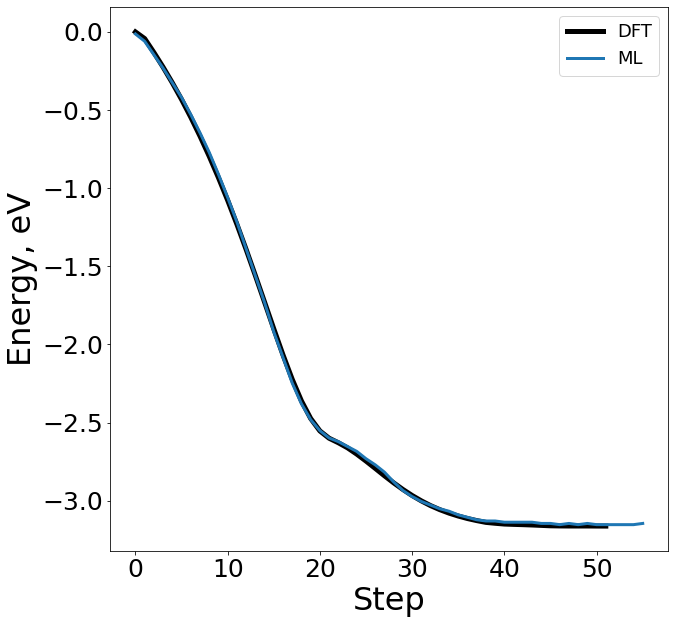

Final AL Relaxed Energy: -66070.9609375
Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.00688115054967852

energy_rmse_AL: 0.0013093021060250555


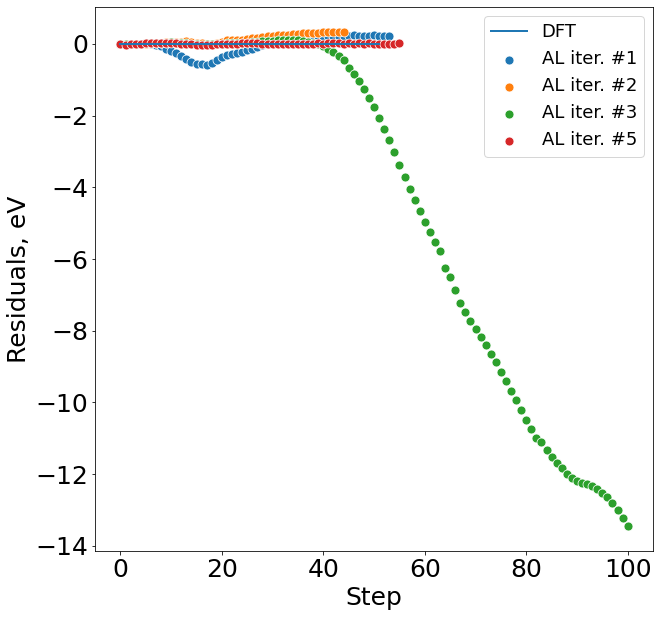

In [255]:
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_5_4_iter_5", parent_traj, compute_parent=False)
residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_5_4",
    parent_traj,
    [1, 2, 3, 5])

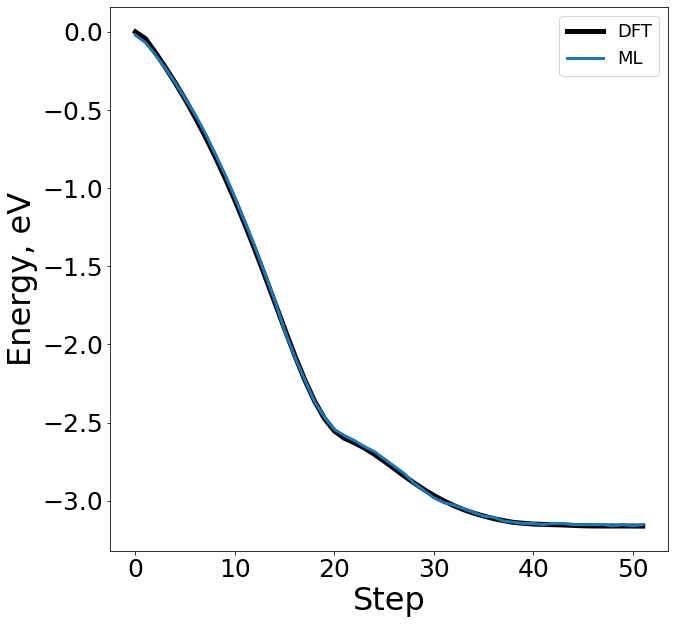

Final AL Relaxed Energy: -66070.96875
Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.007830943816487817

energy_rmse_AL: 0.0007083405675635171


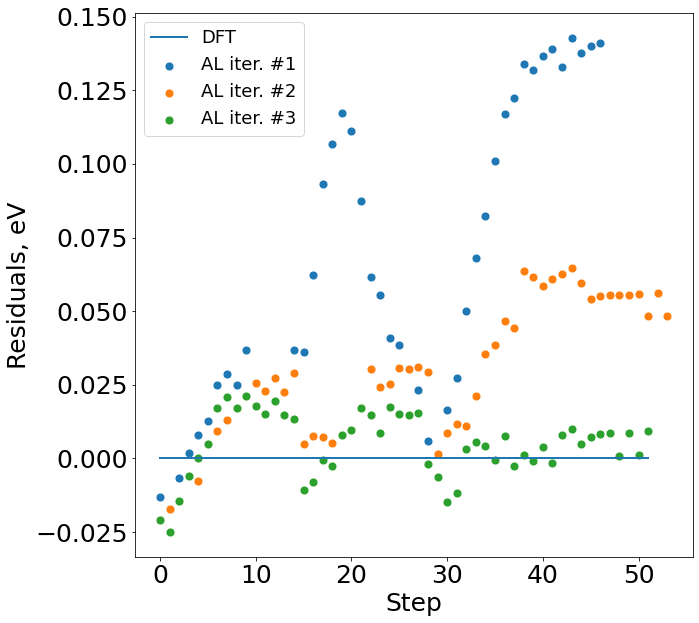

In [256]:
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_3_5_iter_3", parent_traj, compute_parent=False)
residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_3_5",
    parent_traj,
    [1, 2, 3])

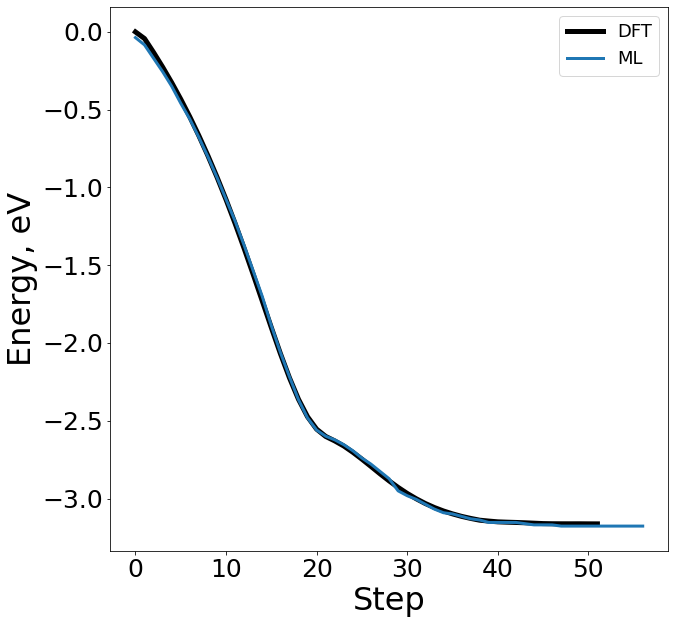

Final AL Relaxed Energy: -66070.9921875
Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.04087307420054645

energy_rmse_AL: 0.0010945440478210982


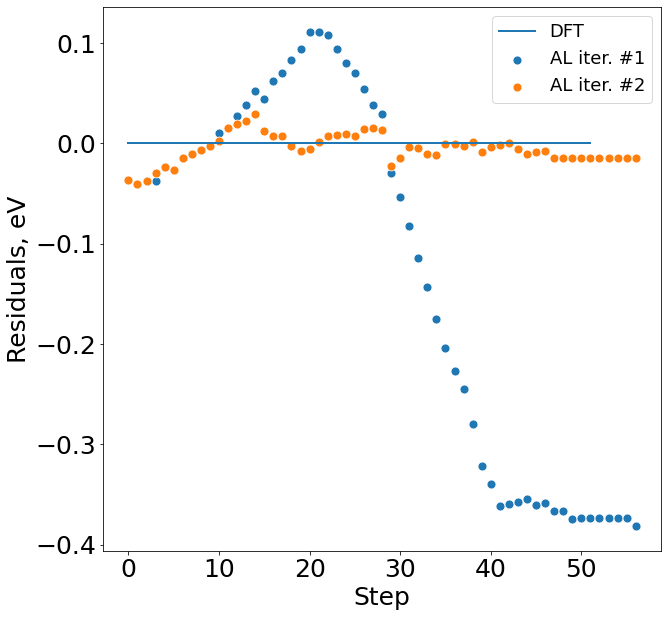

In [257]:
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_2_10_iter_2", parent_traj, compute_parent=False)
residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_2_10",
    parent_traj,
    [1, 2])

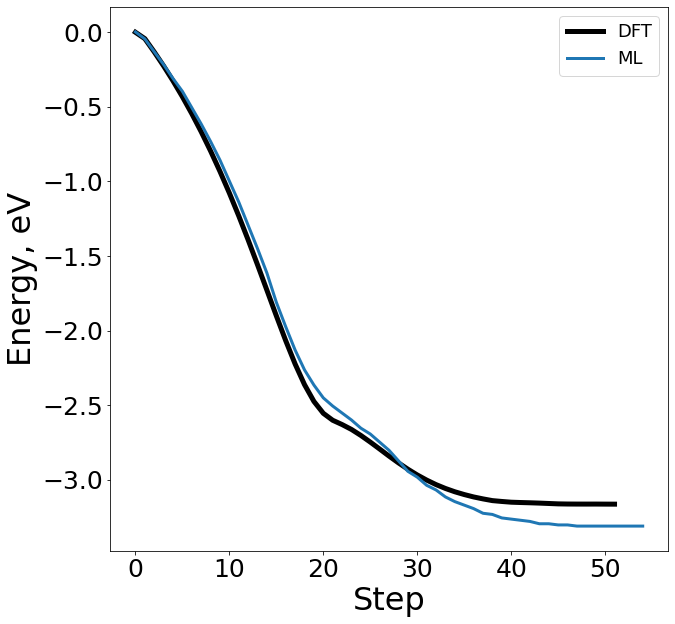

Final AL Relaxed Energy: -66071.125
Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.05849320424118231

energy_rmse_AL: 0.011310890201667253


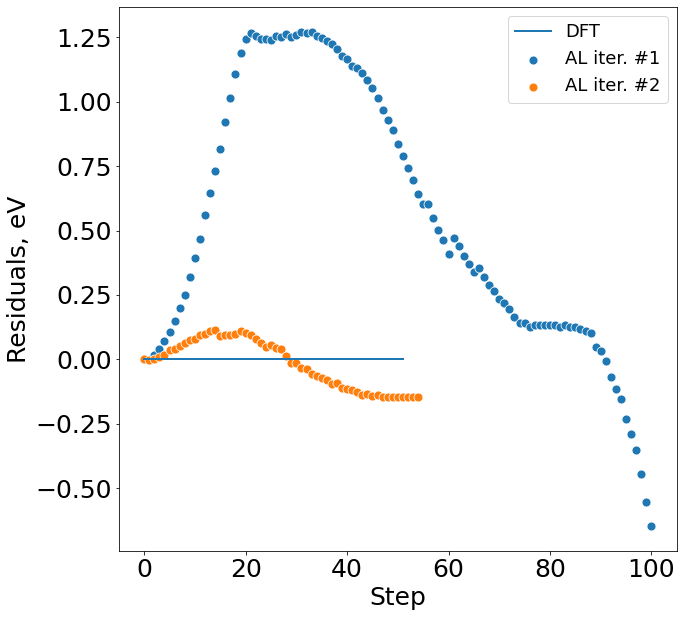

In [258]:
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_2_5_iter_2", parent_traj, compute_parent=False)
residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_2_5",
    parent_traj,
    [1, 2])

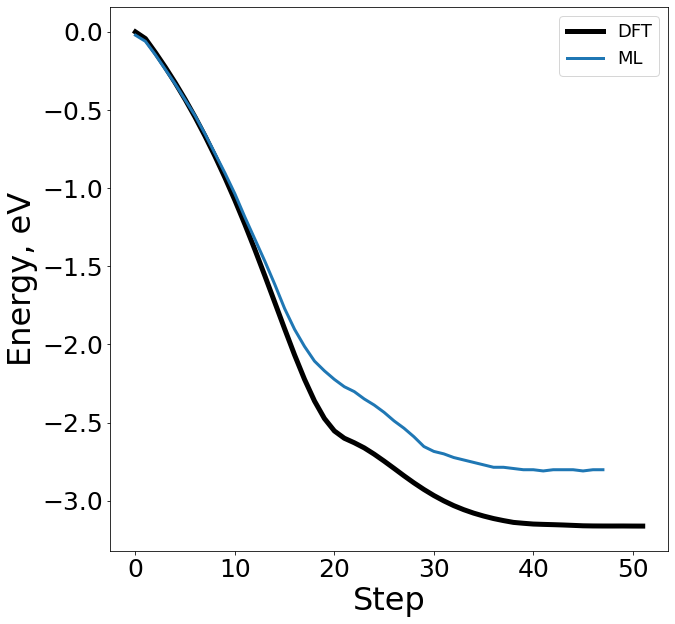

Final AL Relaxed Energy: -66070.6171875
Total number of DFT steps: 52
Final DFT Relaxed Energy: -66070.97795842738

Initial structure rmse: 0.4090976352771832
AL relaxed structure rmse: 0.056419673410292644

energy_rmse_AL: 0.027751609798332747


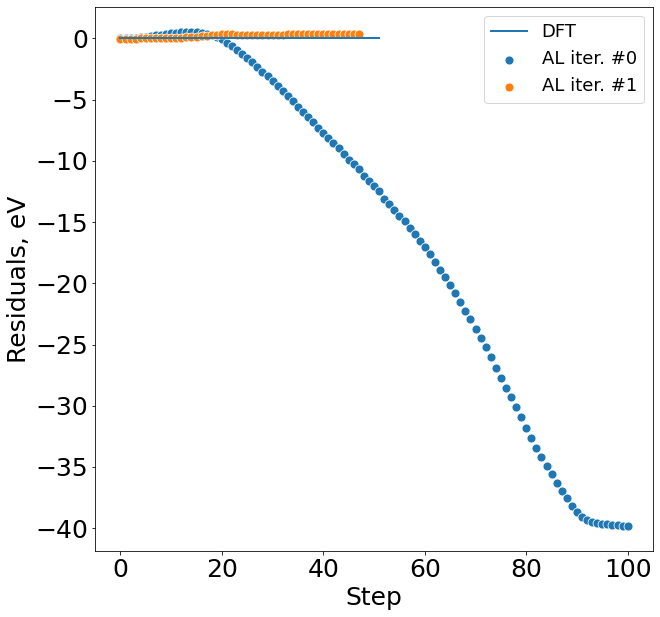

In [259]:
plot_relax("/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_1_5_iter_1", parent_traj, compute_parent=False)
residuals_plot(
    "/content/drive/My Drive/CMU - PhD/Research/AMPTorch/Paper/Runs/al relaxation/delta_relax/delta_relax_1_5",
    parent_traj,
    [0, 1])